In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import itertools
# import higherOrderKME
# from higherOrderKME import sigkernel
import Path_Char
from Path_Char.path_characteristic_function import char_func_path
from Path_Char.high_order_pcf import PCFKernel

# Using seaborn's style
plt.style.use('seaborn-colorblind')
width = 345
tex_fonts = {
    "text.usetex": False,  # put False if this raises errors
    "font.family": "serif",
    "axes.labelsize": 24,
    "font.size": 22,
    "legend.fontsize": 24,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    'figure.figsize': (7, 5),
}
plt.rcParams.update(tex_fonts)

In [2]:
device = 'cuda'

In [3]:
class RBFKernel():
    """RBF kernel k: R^d x R^d -> R"""

    def __init__(self, sigma, add_time=0):
        self.sigma = sigma
        self.add_time = add_time

    def batch_kernel(self, X, Y):
        """Input: 
                  - X: torch tensor of shape (batch, length_X, dim),
                  - Y: torch tensor of shape (batch, length_Y, dim)
           Output: 
                  - matrix k(X^i_s,Y^i_t) of shape (batch, length_X, length_Y)
        """
        A, M, N = X.shape[0], X.shape[1], Y.shape[1]

        Xs = torch.sum(X**2, dim=2)
        Ys = torch.sum(Y**2, dim=2)
        dist = -2.*torch.bmm(X, Y.permute(0, 2, 1))
        dist += torch.reshape(Xs, (A, M, 1)) + torch.reshape(Ys, (A, 1, N))

        if self.add_time != 0:
            fact = 1./self.add_time
            time_component = (fact*torch.arange(X.shape[1], device=X.device, dtype=X.dtype)[:, None]-fact*torch.arange(Y.shape[1], device=Y.device, dtype=Y.dtype)[None, :])**2
            dist += time_component[None, :, :]

        return torch.exp(-dist/self.sigma)

    def Gram_matrix(self, X, Y):
        """Input: 
                  - X: torch tensor of shape (batch_X, length_X, dim),
                  - Y: torch tensor of shape (batch_Y, length_Y, dim)
           Output: 
                  - matrix k(X^i_s,Y^j_t) of shape (batch_X, batch_Y, length_X, length_Y)
        """
        A, B, M, N = X.shape[0], Y.shape[0], X.shape[1], Y.shape[1]

        Xs = torch.sum(X**2, dim=2)
        Ys = torch.sum(Y**2, dim=2)
        dist = -2.*torch.einsum('ipk,jqk->ijpq', X, Y)
        dist += torch.reshape(Xs, (A, 1, M, 1)) + torch.reshape(Ys, (1, B, 1, N))

        if self.add_time:
            fact = 1./self.add_time
            time_component = (fact*torch.arange(X.shape[1], device=X.device, dtype=X.dtype)[:, None]-fact*torch.arange(Y.shape[1], device=Y.device, dtype=Y.dtype)[None, :])**2
            dist += time_component[None, None, :, :]
        return torch.exp(-dist/self.sigma)

In [4]:
# number of path coordinates and number of time steps
D, L = 1, 3 

# experimental setup
repeats, n_samples, n, lambda_ = 100, 500, 5*1e5, 1e-5

MMD_1 = np.zeros((repeats, 2))
MMD_2 = np.zeros((repeats, 2))

# to store the sample paths from X_n and X
X = np.zeros((repeats, n_samples, 2, L, D)) 
X_n = np.zeros((repeats, n_samples, 2, L, D))   

# sample from X_n 
omega_1 = np.random.choice(a=[-1, 1], size=(repeats, n_samples, 2))
omega_2 = np.random.choice(a=[-1, 1], size=(repeats, n_samples, 2))
X_n[:, :, :, 1, 0] = omega_1 * 1./n
X_n[:, :, :, 2, 0] = 0.1 * omega_1

# sample from X
omega_1 = np.random.choice(a=[-1, 1], size=(repeats, n_samples, 2))
X[:, :, :, 2, 0] = 0.1 * omega_1

In [5]:
lie_degree_1 = 4
num_samples_1 = 100
input_size = 1
add_time = False

num_samples_2 = 100
lie_degree_2 = 4

pcf_level_1 = char_func_path(num_samples=num_samples_1, 
                              hidden_size=lie_degree_1, 
                              input_dim=input_size, 
                              add_time=add_time, 
                              include_initial = False)

pcf_level_2 = char_func_path(num_samples=num_samples_2, 
                              hidden_size=lie_degree_2, 
                              input_dim=lie_degree_1**2, 
                              add_time=add_time, 
                              include_initial = False)

pcf_level_1.to(device)
pcf_level_2.to(device)

char_func_path(
  (unitary_development): development_layer(
    (projection): projection(
      (param_map): unitary()
    )
  )
)

In [7]:
kernel_order1 = PCFKernel(pcf_level_1)
kernel_order2 = PCFKernel([pcf_level_1, pcf_level_2])

In [9]:
for i in tqdm(range(repeats)):

    x0 = torch.tensor(X[i, :, 0, :, :], dtype=torch.float64).to(device)     # X of shape (repeats,n_samples,2,L,D)
    x0_ = torch.tensor(X[i, :, 1, :, :], dtype=torch.float64).to(device)    # independent copy of X
    xn = torch.tensor(X_n[i, :, 0, :, :], dtype=torch.float64).to(device)
    xn_ = torch.tensor(X_n[i, :, 1, :, :], dtype=torch.float64).to(device)  # independent copy of X_n

    MMD_2[i,0] = kernel_order2.compute_mmd(x0, x0_, order=2)   
    MMD_2[i,1] = kernel_order2.compute_mmd(xn, x0, order=2)   
    
    MMD_1[i,0] = kernel_order1.compute_mmd(x0, x0_, order=1)   
    MMD_1[i,1] = kernel_order1.compute_mmd(xn, x0, order=1)   

  0%|          | 0/100 [00:00<?, ?it/s]

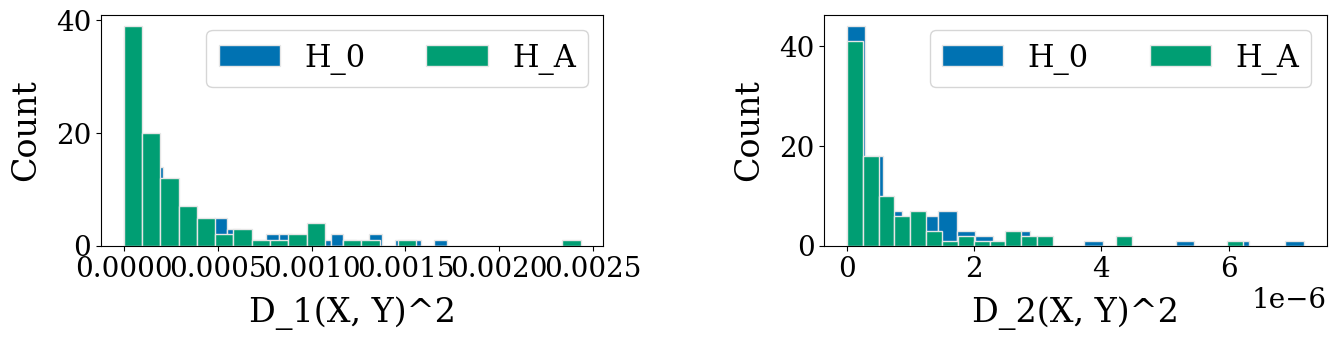

In [10]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].hist(MMD_1[:,0], bins=25, label='H_0',edgecolor='#E6E6E6')
ax[0].hist(MMD_1[:,1], bins=25, label='H_A',edgecolor='#E6E6E6')

ax[0].legend(loc='upper right', ncol=2, fontsize=22)
ax[0].set_xlabel('D_1(X, Y)^2', labelpad=10)
ax[0].set_ylabel('Count', labelpad=10)

ax[1].hist(MMD_2[:,0], bins=25, label='H_0', edgecolor='#E6E6E6')
ax[1].hist(MMD_2[:,1], bins=25, label='H_A', edgecolor='#E6E6E6')

ax[1].legend(loc='upper right', ncol=2, fontsize=22)
ax[1].set_xlabel('D_2(X, Y)^2', labelpad=10)
ax[1].set_ylabel('Count', labelpad=10)

plt.tight_layout(pad=3.0)
# plt.savefig('MMD_binary_tex.pdf',bbox_inches='tight')
plt.show()